# IMPORT STATEMENTS

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 graphviz

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.impute import SimpleImputer

2.1.0
2.2.4


Using TensorFlow backend.
/home/mgill/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    print(tt_pheno.shape)
            
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "PoC_Merged_filtered.csv_holdout.csv_5pcnt.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(617,)
(617, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(155,)
(155, 1)
220000
(617, 214899)
(155, 214899)
(617, 1)


In [ ]:
#if it hasn't been run and saved before
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)

In [ ]:
pickle.dump(ohe, open("PoC_ohe.dat", "wb"))

In [4]:
#if need or have new holdout data etc.
ohe = pickle.load(open("PoC_ohe.dat", "rb"))

In [14]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 214899)
(617, 623207)
(155, 214899)
(155, 623207)


In [5]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [6]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 462793)
print(my_snp)

T/C


# XGBOOST ML Model

In [17]:
##ONLY NEED TO DO IF OPTIMISING

print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

(617, 623207)
(617, 1)
(124, 623207)
seed is 2431


In [18]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

In [19]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [20]:
xgbcl = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
xgb_bayes_search = BayesSearchCV(xgbcl, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:10] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:34:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.770, total= 2.8min
[CV] colsample_bylevel=0.416002919

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[14:36:58] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:37:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.778, total= 2.5min
[CV] colsample_bylevel=0.416002919

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s


[14:39:30] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:39:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.778, total= 2.5min
[CV] colsample_bylevel=0.416002919

[14:58:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.18630307921210337, colsample_bytree=0.6357746718688816, gamma=4.759632988007942e-09, learning_rate=0.21560448660617149, max_delta_step=14, max_depth=39, min_child_weight=0, n_estimators=198, reg_alpha=1.307103676304351e-05, reg_lambda=1.1326211354138217e-09, scale_pos_weight=22.356393886375308, subsample=0.7121579996266859, score=0.857, total= 4.0min
[CV] colsample_bylevel=0.18630307921210337, colsample_bytree=0.6357746718688816, gamma=4.759632988007942e-09, learning_rate=0.21560448660617149, max_delta_step=14, max_depth=39, min_child_weight=0, n_estimators=198, reg_alpha=1.307103676304351e-05, reg_lambda=1.1326211354138217e-09, scale_pos_weight=22.356393886375308, subsample=0.7121579996266859 
[15:02:21] WARNIN

[15:13:29] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909265e-09, scale_pos_weight=6.97020795804701e-06, subsample=0.46717487628832827, score=0.800, total=  43.1s
[CV] colsample_bylevel=0.7711308

[15:21:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.9132100359267209, colsample_bytree=0.7679711803126804, gamma=2.428808912219129e-07, learning_rate=0.03511167856740689, max_delta_step=3, max_depth=8, min_child_weight=4, n_estimators=197, reg_alpha=0.023358352781682152, reg_lambda=2.1396512525873352e-07, scale_pos_weight=0.001760608876847004, subsample=0.15990388740095085, score=0.778, total= 4.0min
[CV] colsample_bylevel=0.9132100359267209, colsample_bytree=0.7679711803126804, gamma=2.428808912219129e-07, learning_rate=0.03511167856740689, max_delta_step=3, max_depth=8, min_child_weight=4, n_estimators=197, reg_alpha=0.023358352781682152, reg_lambda=2.1396512525873352e-07, scale_pos_weight=0.001760608876847004, subsample=0.15990388740095085 
[15:25:19] WARNING:

[15:39:54] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:39:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=0.561, total=  41.4s
[CV] colsample_bylevel=0.356907918073

[CV]  colsample_bylevel=0.3173884684879576, colsample_bytree=0.9154083808190769, gamma=0.37957777315906627, learning_rate=0.046564465205051725, max_delta_step=5, max_depth=25, min_child_weight=4, n_estimators=98, reg_alpha=1.8932210348902655e-05, reg_lambda=10.393593598030753, scale_pos_weight=0.019183460268621746, subsample=0.6299477217301774, score=0.845, total= 2.3min
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[15:52:17] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  ve

[16:03:02] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:03:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.06936552953088004, colsample_bytree=0.5708703891954323, gamma=1.9956389638103137e-08, learning_rate=0.09010297955022104, max_delta_step=9, max_depth=25, min_child_weight=2, n_estimators=139, reg_alpha=0.9824119669778386, reg_lambda=0.00017577858139476563, scale_pos_weight=261.4450653749918, subsample=0.14242164035537377, score=0.788, total= 1.7min
[CV] colsample_bylevel=0.0693655295

[16:12:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.1798648261515349, colsample_bytree=0.1536154650973617, gamma=2.692171045057089e-07, learning_rate=0.031045751168128115, max_delta_step=12, max_depth=24, min_child_weight=3, n_estimators=113, reg_alpha=0.0011518554964803237, reg_lambda=3.9270934206560135e-05, scale_pos_weight=0.036328353682153036, subsample=0.5123744729843144, score=0.768, total= 1.2min
[CV] colsample_bylevel=0.1798648261515349, colsample_bytree=0.1536154650973617, gamma=2.692171045057089e-07, learning_rate=0.031045751168128115, max_delta_step=12, max_depth=24, min_child_weight=3, n_estimators=113, reg_alpha=0.0011518554964803237, reg_lambda=3.9270934206560135e-05, scale_pos_weight=0.036328353682153036, subsample=0.5123744729843144 
[16:13:24] WA

[16:24:06] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:24:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086, score=0.856, total= 2.1min
[CV] colsample_bylevel=0.885427980014

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 122.6min finished


best score: 0.8559837728194726
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:54] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:36:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0, score=0.570, total=  26.7s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weigh

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s remaining:    0.0s


[16:37:20] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0, score=0.566, total=  24.8s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weigh

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.7s remaining:    0.0s


[16:37:45] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0, score=0.566, total=  26.5s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weigh

[16:44:41] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:44:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4768509039736716, colsample_bytree=1.0, gamma=0.0025881548048269907, learning_rate=0.12457587154455696, max_delta_step=7, max_depth=7, min_child_weight=2, n_estimators=50, reg_alpha=4.421859999060103e-08, reg_lambda=199.35959016985052, scale_pos_weight=1e-06, subsample=0.9701311374674002, score=0.876, total= 1.4min
[CV] colsample_bylevel=0.8443052635102495, colsample_bytree=1.0, gam

[17:00:58] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:01:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=0, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.788, total=  28.4s
[CV] colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=0, max_depth=50, min_child_weight=0, n_estima

[17:04:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.5992809585319264, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.37772584733452497, max_delta_step=20, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1.2504173134846927e-07, reg_lambda=1000.0, scale_pos_weight=0.8285422508663005, subsample=1.0, score=0.571, total=  28.5s
[CV] colsample_bylevel=0.5992809585319264, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.37772584733452497, max_delta_step=20, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1.2504173134846927e-07, reg_lambda=1000.0, scale_pos_weight=0.8285422508663005, subsample=1.0 
[17:04:48] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some paramet

[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.06083328540655388, max_delta_step=0, max_depth=50, min_child_weight=2, n_estimators=50, reg_alpha=1e-09, reg_lambda=0.003070765266077698, scale_pos_weight=1e-06, subsample=0.7786806739694166, score=0.850, total= 1.9min
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.06083328540655388, max_delta_step=0, max_depth=50, min_child_weight=2, n_estimators=50, reg_alpha=1e-09, reg_lambda=0.003070765266077698, scale_pos_weight=1e-06, subsample=0.7786806739694166 
[17:13:57] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:14:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation 

[17:22:39] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:22:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=0.01, score=0.571, total=  26.5s
[CV] colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, m

[17:25:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.690, total=  34.0s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=20, max_depth=50, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=1.0 
[17:26:20] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost 

[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.02033988572040353, colsample_bytree=0.6867075332192113, gamma=0.00010085792273827948, learning_rate=0.09909420592676477, max_delta_step=11, max_depth=28, min_child_weight=5, n_estimators=59, reg_alpha=5.19048059662466e-09, reg_lambda=1.895793252681232e-09, scale_pos_weight=0.7286137596066893, subsample=0.8422629944483357, score=0.768, total= 1.1min
[CV] colsample_bylevel=0.02033988572040353, colsample_bytree=0.6867075332192113, gamma=0.00010085792273827948, learning_rate=0.09909420592676477, max_delta_step=11, max_depth=28, min_child_weight=5, n_estimators=59, reg_alpha=5.19048059662466e-09, reg_lambda=1.895793252681232e-09, scale_pos_weight=0.7286137596066893, subsample=0.8422629944483357 
[17:31:48] WARNING: .

[17:37:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=20, max_depth=50, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.835, total=  53.6s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 61.0min finished


best score: 0.8620689655172413
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.48822684112670245, colsample_bytree=0.7605772669100791, gamma=3.102622104751858e-08, learning_rate=0.20386878491795582, max_delta_step=9, max_depth=26, min_child_weight=0, n_estimators=105, reg_alpha=2.9226281370072575e-06, reg_lambda=1000.0, scale_pos_weight=0.0028734416587893508, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:58] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:38:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.48822684112670245, colsample_bytree=0.7605772669100791, gamma=3.102622104751858e-08, learning_rate=0.20386878491795582, max_delta_step=9, max_depth=26, min_child_weight=0, n_estimators=105, reg_alpha=2.9226281370072575e-06, reg_lambda=1000.0, scale_pos_weight=0.0028734416587893508, subsample=1.0, score=0.850, total= 4.3min
[CV] colsample_bylevel=0.48822684112670245, colsample_bytree

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[17:42:18] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:42:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.48822684112670245, colsample_bytree=0.7605772669100791, gamma=3.102622104751858e-08, learning_rate=0.20386878491795582, max_delta_step=9, max_depth=26, min_child_weight=0, n_estimators=105, reg_alpha=2.9226281370072575e-06, reg_lambda=1000.0, scale_pos_weight=0.0028734416587893508, subsample=1.0, score=0.828, total= 4.3min
[CV] colsample_bylevel=0.48822684112670245, colsample_bytree

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.6min remaining:    0.0s


[17:46:37] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:46:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.48822684112670245, colsample_bytree=0.7605772669100791, gamma=3.102622104751858e-08, learning_rate=0.20386878491795582, max_delta_step=9, max_depth=26, min_child_weight=0, n_estimators=105, reg_alpha=2.9226281370072575e-06, reg_lambda=1000.0, scale_pos_weight=0.0028734416587893508, subsample=1.0, score=0.848, total= 4.0min
[CV] colsample_bylevel=0.48822684112670245, colsample_bytree

[CV]  colsample_bylevel=0.14683089443311095, colsample_bytree=0.9994449561597772, gamma=4.593920824030072e-09, learning_rate=0.14885404747775002, max_delta_step=0, max_depth=50, min_child_weight=0, n_estimators=83, reg_alpha=7.985517464495955e-09, reg_lambda=9.480081417491835, scale_pos_weight=1.0707843615848027e-06, subsample=0.053470408016864805, score=0.724, total= 1.2min
[CV] colsample_bylevel=0.14683089443311095, colsample_bytree=0.9994449561597772, gamma=4.593920824030072e-09, learning_rate=0.14885404747775002, max_delta_step=0, max_depth=50, min_child_weight=0, n_estimators=83, reg_alpha=7.985517464495955e-09, reg_lambda=9.480081417491835, scale_pos_weight=1.0707843615848027e-06, subsample=0.053470408016864805 
[18:03:28] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this


[18:19:12] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7846176622243527, colsample_bytree=0.972829065423114, gamma=1.3483631756165142e-05, learning_rate=0.0397336756042424, max_delta_step=8, max_depth=16, min_child_weight=0, n_estimators=147, reg_alpha=0.01558887411264243, reg_lambda=6.474799133946946, scale_pos_weight=2.746113892093292e-06, subsample=0.6707614366879879, score=0.850, total= 6.9min
[CV] colsample_bylevel=0.78461766222435

[CV]  colsample_bylevel=0.07210635895242454, colsample_bytree=0.7983847077302229, gamma=1e-09, learning_rate=0.025184339136998492, max_delta_step=10, max_depth=29, min_child_weight=2, n_estimators=180, reg_alpha=0.0374170096509949, reg_lambda=1.1873995590128428, scale_pos_weight=0.8379344744529977, subsample=0.8987752907001196, score=0.838, total= 2.9min
[CV] colsample_bylevel=0.07210635895242454, colsample_bytree=0.7983847077302229, gamma=1e-09, learning_rate=0.025184339136998492, max_delta_step=10, max_depth=29, min_child_weight=2, n_estimators=180, reg_alpha=0.0374170096509949, reg_lambda=1.1873995590128428, scale_pos_weight=0.8379344744529977, subsample=0.8987752907001196 
[19:00:14] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if yo

[19:19:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.3649766029594872, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.27743611891638503, max_delta_step=4, max_depth=50, min_child_weight=1, n_estimators=198, reg_alpha=1.3468386879342492e-09, reg_lambda=7.00425315341386e-05, scale_pos_weight=1e-06, subsample=0.7675329374838437, score=0.898, total= 2.9min
[CV] colsample_bylevel=0.3649766029594872, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.27743611891638503, max_delta_step=4, max_depth=50, min_child_weight=1, n_estimators=198, reg_alpha=1.3468386879342492e-09, reg_lambda=7.00425315341386e-05, scale_pos_weight=1e-06, subsample=0.7675329374838437 
[19:21:51] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not

[19:38:30] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:38:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.5156713964316169, colsample_bytree=0.9393361153664864, gamma=8.192997405245567e-05, learning_rate=0.6319965814108763, max_delta_step=6, max_depth=34, min_child_weight=1, n_estimators=178, reg_alpha=4.425087335578294e-09, reg_lambda=0.024629886028452785, scale_pos_weight=1e-06, subsample=0.7578492056623087, score=0.840, total= 2.6min
[CV] colsample_bylevel=0.5156713964316169, colsamp

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 133.1min finished


best score: 0.8620689655172413


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:51:05] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:51:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 1e-09), ('learning_rate', 0.06083328540655388), ('max_delta_step', 0), ('max_depth', 50), ('min_child_weight', 2), ('n_estimators', 50), ('reg_alpha', 1e-09), ('reg_lambda', 0.003070765266077698), ('scale_pos_weight', 1e-06), ('subsample', 0.7786806739694166)])


In [21]:
print(xgb_bayes_search.best_params_)
model = xgb.XGBClassifier(**xgb_bayes_search.best_params_, objective='multi:softmax', num_class=3)

OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 1e-09), ('learning_rate', 0.06083328540655388), ('max_delta_step', 0), ('max_depth', 50), ('min_child_weight', 2), ('n_estimators', 50), ('reg_alpha', 1e-09), ('reg_lambda', 0.003070765266077698), ('scale_pos_weight', 1e-06), ('subsample', 0.7786806739694166)])


In [ ]:
##if not in same run as optimisation
best_params = OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 1e-09), ('learning_rate', 0.06083328540655388), ('max_delta_step', 0), ('max_depth', 50), ('min_child_weight', 2), ('n_estimators', 50), ('reg_alpha', 1e-09), ('reg_lambda', 0.003070765266077698), ('scale_pos_weight', 1e-06), ('subsample', 0.7786806739694166)])
model = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=3)

In [ ]:
## DO MORE STUFF HERE when OPTIMISED

In [7]:
def eval_k_fold(m, x, y, k, hx, hy):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    fig1 = plt.figure(figsize=[12,12])

    tprs = []
    aucs = []
    results = []
    mean_fpr = np.linspace(0,1,100)
    high = 0
    best = m
    i = 1
    for train,test in cv.split(x,y):
        prediction = m.fit(x[train],y[train].ravel()).predict_proba(x[test])
        print("variables for auroc curve done. Processing fold accuracy + checking best model")
        y_pred = m.predict(x[test])
        predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        accuracy = accuracy_score(y[test], predictions)
        pcent = accuracy * 100.0
        print("The accuracy of this model is" + str(pcent))
        if(pcent > high):
            high = pcent
            best = m
       # fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
       # tprs.append(interp(mean_fpr, fpr, tpr))
       # roc_auc = auc(fpr, tpr)
       # aucs.append(roc_auc)
        results.append(pcent)
       # plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

   # plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
   # mean_tpr = np.mean(tprs, axis=0)
   # mean_auc = auc(mean_fpr, mean_tpr)
   # plt.plot(mean_fpr, mean_tpr, color='blue',
    #         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    
    holdout_pred = best.predict(hx)
    predictions = [round(value) for value in holdout_pred]
    #sees how accurate the model was when testing the test set
    accuracy = accuracy_score(hy, predictions)
    pcent = accuracy * 100.0
    print(pcent)
    xgb_predictions = best.predict(hx)
    xgb_probs = best.predict_proba(hx)[:, 1]
    #model_fpr, model_tpr, my_roccy = evaluate_model(xgb_predictions, xgb_probs, hy)
    #plt.plot(model_fpr, model_tpr, 'r', label = 'Holdout Data'+my_roccy, lw=2)
    
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Flower Colour Training Model & Holdout Data')
    #plt.legend(loc="lower right")
    #plt.show()

    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    print("Holdout Accuracy: %.2f%%" % (pcent))
    
    return best

In [23]:
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
 #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
best_model = eval_k_fold(model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

(617, 623207)
(617, 1)
(155, 623207)
(155, 1)


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:00] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:48:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is85.71428571428571
[22:51:11] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificatio

<Figure size 864x864 with 0 Axes>

In [24]:
import pickle
pickle.dump(best_model, open("PoC_kfold_10_tt_from_all.pickle.dat", "wb"))

In [7]:
#only load if not generated in same session
best_model = pickle.load(open("PoC_kfold_10_tt_from_all.pickle.dat", "rb"))

In [ ]:
## DO SNPS of importance

<Figure size 1440x1440 with 0 Axes>

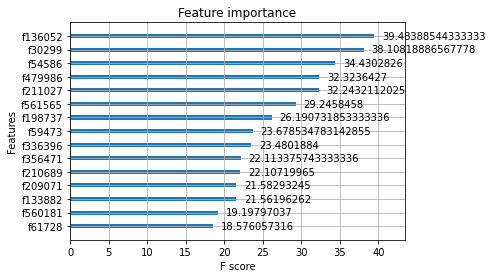

In [8]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("FC_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [9]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("PoC_Merged_filtered.csv_train_test.csv_5pcnt.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 28537
(617, 28537)
my header list is: 28537
my X value is: 57374
(617, 28837)
my header list is: 57374
my X value is: 86375
(617, 29001)
my header list is: 86375
my X value is: 115537
(617, 29162)
my header list is: 115537
my X value is: 144307
(617, 28770)
my header list is: 144307
my X value is: 173535
(617, 29228)
my header list is: 173535
my X value is: 202727
(617, 29192)
my header list is: 202727
my X value is: 231683
(617, 28956)
my header list is: 231683
my X value is: 260481
(617, 28798)
my header list is: 260481
my X value is: 289251
(617, 28770)
my header list is: 289251
my X value is: 318304
(617, 29053)
my header list is: 318304
my X value is: 347245
(617, 28941)
my header list is: 347245
my X value is: 376423
(617, 29178)
my header list is: 376423
my X value is: 405294
(617, 28871)
my header list is: 405294
my X value is: 434640
(617, 29346)
my header list is: 434640
my X value is: 463726
(617, 29086)
my header list is: 463726
my X value is: 492911
(617, 29

Gm05_11968079 (A/A)
Gm01_55053811 (T/T)
Gm02_41961414 (A/A)
Gm17_6746570 (C/C)
Gm08_183702 (G/G)
Gm19_6434610 (A/A)
Gm07_17356456 (A/A)
Gm02_49207571 (C/C)
Gm12_18950685 (A/A)
Gm13_16076593 (G/G)
Gm07_45624847 (C/C)
Gm07_42559917 (T/T)
Gm05_6303805 (A/A)
Gm19_4824644 (A/A)
Gm03_642218 (C/C)
15
15


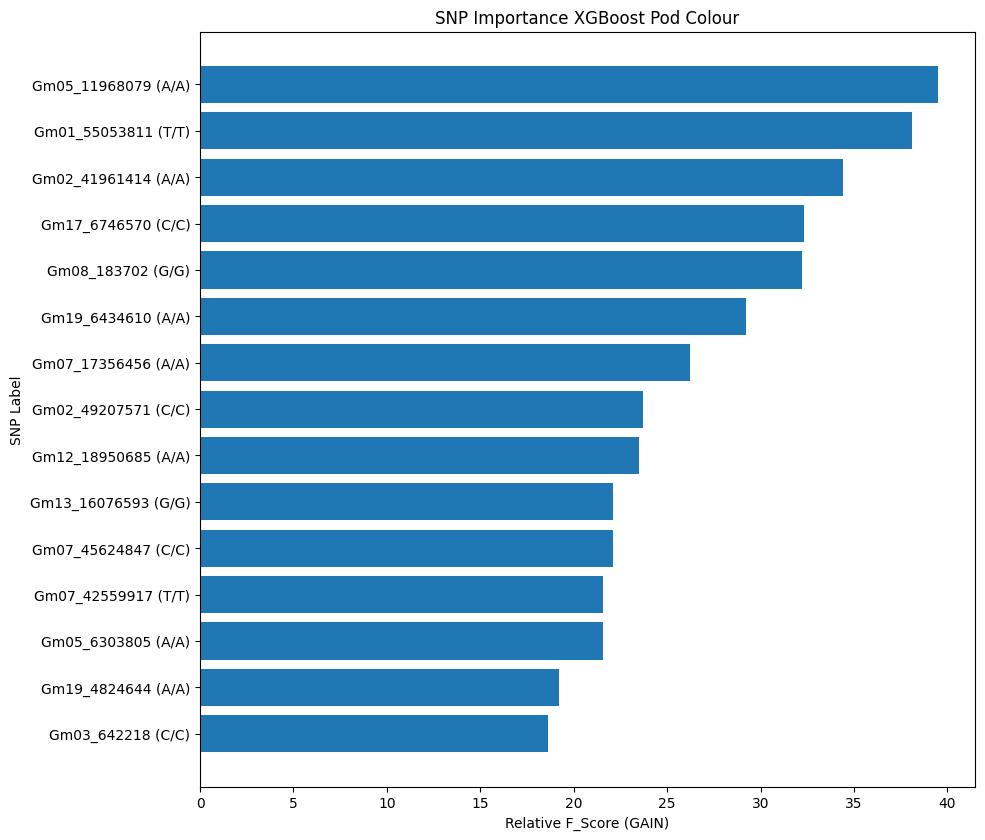

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [136052,30299,54586,479986,211027,561565,198737,59473,336396,356471,210689,209071,133882,560181,61728]
scores = [39.5,38.1,34.4,32.3,32.2,29.2,26.2,23.7,23.5,22.113,22.107,21.58,21.56,19.2,18.6]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Pod Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [10]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [11]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [12]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


In [13]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm03_642218 (C/C)      18.576057
Gm01_4670080 (G/G)      0.414410
Gm08_183702 (G/G)      32.243211
Gm03_481617 (C/C)       9.107324
Gm17_28441916 (C/T)     6.203692
                         ...    
Gm05_42185208 (G/G)     0.691419
Gm16_4456665 (A/A)      0.497086
Gm01_52694957 (A/A)     0.086651
Gm01_44369368 (A/A)     0.002682
Gm15_39127919 (T/T)     0.352772
Length: 2093, dtype: float64
                     F_Score(GAIN)
Gm03_642218 (C/C)        18.576057
Gm01_4670080 (G/G)        0.414410
Gm08_183702 (G/G)        32.243211
Gm03_481617 (C/C)         9.107324
Gm17_28441916 (C/T)       6.203692
...                            ...
Gm05_42185208 (G/G)       0.691419
Gm16_4456665 (A/A)        0.497086
Gm01_52694957 (A/A)       0.086651
Gm01_44369368 (A/A)       0.002682
Gm15_39127919 (T/T)       0.352772

[2093 rows x 1 columns]


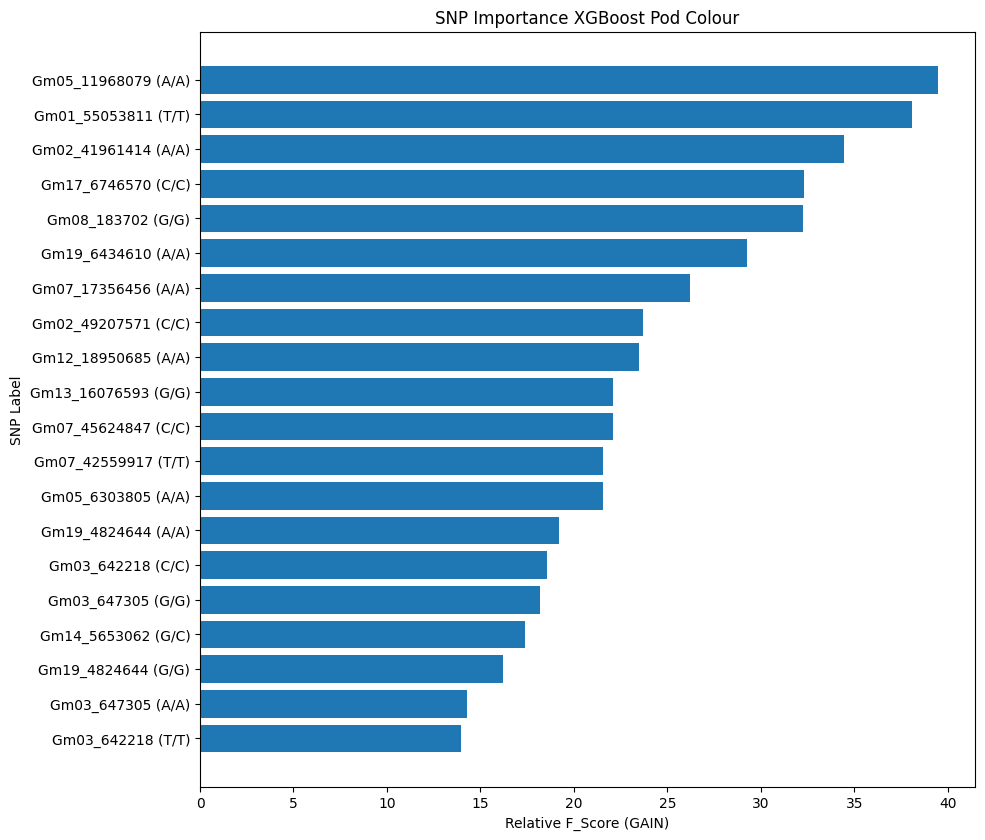

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Pod Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

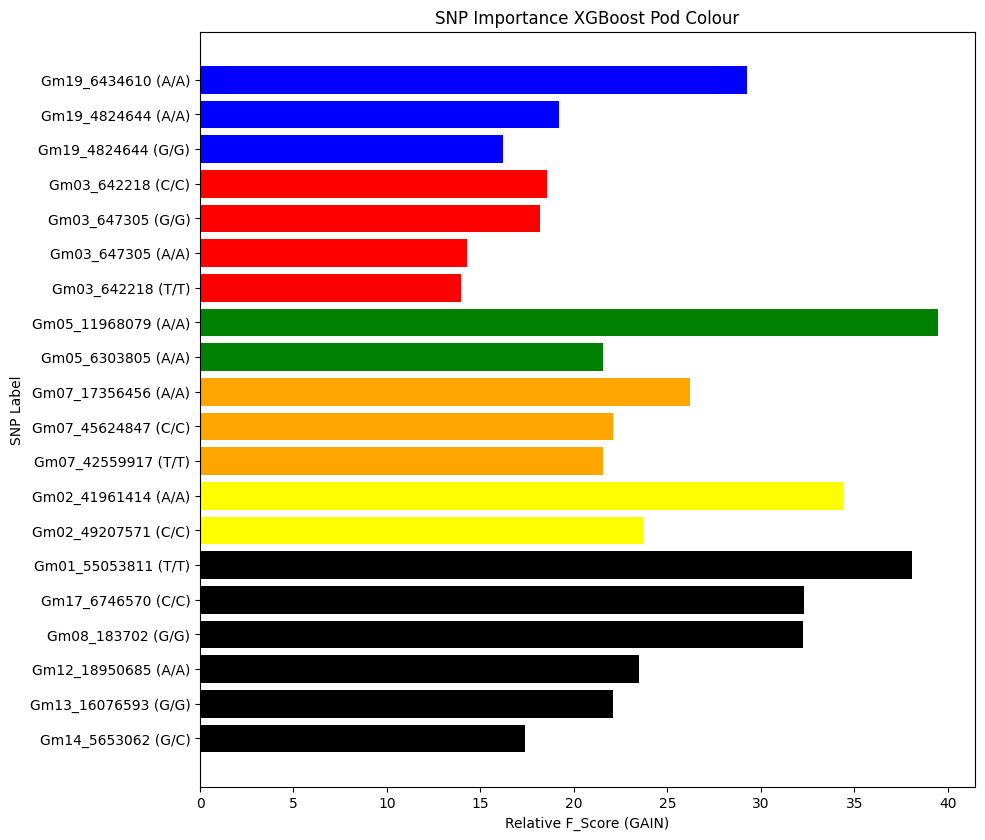

In [18]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm03' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm19' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm05' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm02' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm07' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(g_i, g_v, color="green")
plt.barh(r_i, r_v, color="red")
plt.barh(b_i, b_v, color="blue")
plt.title('SNP Importance XGBoost Pod Colour')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# RL Model

In [19]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "PoC_Merged_filtered.csv_holdout.csv_5pcnt.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(617,)
(617, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(155,)
(155, 1)
220000
(617, 214899)
(155, 214899)
(617, 1)
0.0
(617, 1)
(155, 1)


In [20]:
#if need or have new holdout data etc.
ohe = pickle.load(open("PoC_ohe.dat", "rb"))

In [21]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 214899)
(617, 623207)
(155, 214899)
(155, 623207)


In [22]:
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
seed = randint(0,5000)
 #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_features = 'sqrt',n_jobs=1, verbose = 1)
best_model = eval_k_fold(model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

(617, 623207)
(617, 1)
(155, 623207)
(155, 1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is79.36507936507937


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is79.36507936507937


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is90.47619047619048


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is80.95238095238095


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is75.80645161290323


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is73.77049180327869


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is80.32786885245902


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is63.934426229508205


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is65.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy of this model is63.33333333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


76.12903225806451


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Testing Accuracy: 75.23% (8.38%)
Holdout Accuracy: 76.13%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


<Figure size 864x864 with 0 Axes>

# CNN (based off primer paper and Philipp)

In [8]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "PoC_Merged_filtered.csv_holdout.csv_5pcnt.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(617,)
(617, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(155,)
(155, 1)
220000
(617, 214899)
(155, 214899)
(617, 1)
0.0
(617, 1)
(155, 1)


In [9]:
ohe = pickle.load(open("PoC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 623207)
(155, 214899)
(155, 623207)


In [10]:
##how to mlb both tt and ho for same scheme? do i even need to?

mlb = MultiLabelBinarizer()
mlb = mlb.fit(tt_pheno)
##print(tt_pheno.shape)
#print(ho_pheno.shape)
#tt_pheno = mlb.transform(tt_pheno)
#print(tt_pheno.shape)
#ho_pheno = mlb.transform(ho_pheno)
#print(ho_pheno.shape)

In [14]:
def build_CNN_model(x_len):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(x_len, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('linear'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=6, kernel_size=6, 
                     input_shape=(8, 1)))
    model.add(Activation('linear'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(24, activation='linear'))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(8, activation='linear'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='softmax'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())
    return model

In [15]:
def eval_cnn(x,y,k,mlb):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        print(y.shape)
        print(y[train])
        if(i==1):
            y = mlb.transform(y)
            print(y.shape)
            print(y[train])
        x = x.reshape(x.shape[0], x.shape[1], 1)
        model = build_CNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/20)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [16]:
best_CNN = eval_cnn(tt_vcf, tt_pheno, 10, mlb)

(617, 1)
[[1.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 

554/554 [==============================] - 5s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.6316 - val_accuracy: 0.8254
Epoch 73/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6091 - val_accuracy: 0.8254
Epoch 74/100
554/554 [==============================] - 5s 10ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.5990 - val_accuracy: 0.8254
Epoch 75/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6589 - val_accuracy: 0.8254
Epoch 76/100
554/554 [==============================] - 5s 10ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.6815 - val_accuracy: 0.8413
Epoch 77/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5646 - val_accuracy: 0.8254
Epoch 78/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6423 - val_accura

554/554 [==============================] - 5s 10ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7860 - val_accuracy: 0.7937
Epoch 67/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.7670 - val_accuracy: 0.7937
Epoch 68/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.7729 - val_accuracy: 0.7937
Epoch 69/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8265 - val_accuracy: 0.7937
Epoch 70/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8901 - val_accuracy: 0.8095
Epoch 71/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.7833 - val_accuracy: 0.7937
Epoch 72/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.8209 - val_accurac

554/554 [==============================] - 5s 9ms/sample - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.4720 - val_accuracy: 0.8730
Epoch 61/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0110 - accuracy: 0.9982 - val_loss: 0.7380 - val_accuracy: 0.7619
Epoch 62/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5357 - val_accuracy: 0.8254
Epoch 63/100
554/554 [==============================] - 5s 10ms/sample - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.4954 - val_accuracy: 0.8889
Epoch 64/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.5681 - val_accuracy: 0.8254
Epoch 65/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.8413
Epoch 66/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5062 - val_accurac

Train on 554 samples, validate on 63 samples
Epoch 1/100
554/554 [==============================] - 35s 64ms/sample - loss: 1.0445 - accuracy: 0.5686 - val_loss: 0.6759 - val_accuracy: 0.7302
Epoch 2/100
554/554 [==============================] - 5s 10ms/sample - loss: 0.7499 - accuracy: 0.6697 - val_loss: 0.9286 - val_accuracy: 0.6032
Epoch 3/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.7364 - accuracy: 0.6986 - val_loss: 1.2138 - val_accuracy: 0.2540
Epoch 4/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.6913 - accuracy: 0.7076 - val_loss: 1.4230 - val_accuracy: 0.2063
Epoch 5/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.6755 - accuracy: 0.7148 - val_loss: 1.5814 - val_accuracy: 0.2063
Epoch 6/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.6768 - accuracy: 0.7220 - val_loss: 1.8328 - val_accuracy: 0.1746
Epoch 7/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.572

Epoch 57/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.5512 - val_accuracy: 0.7937
Epoch 58/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.6072 - val_accuracy: 0.7937
Epoch 59/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.7056 - val_accuracy: 0.8254
Epoch 60/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.5953 - val_accuracy: 0.7937
Epoch 61/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.5785 - val_accuracy: 0.7937
Epoch 62/100
554/554 [==============================] - 5s 9ms/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5359 - val_accuracy: 0.8095
Epoch 63/100
554/554 [==============================] - 5s 10ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5919 

Train on 555 samples, validate on 62 samples
Epoch 1/100
555/555 [==============================] - 31s 56ms/sample - loss: 0.9560 - accuracy: 0.6126 - val_loss: 0.7096 - val_accuracy: 0.7097
Epoch 2/100
555/555 [==============================] - 6s 10ms/sample - loss: 0.7951 - accuracy: 0.6595 - val_loss: 0.8844 - val_accuracy: 0.6290
Epoch 3/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.7175 - accuracy: 0.6919 - val_loss: 1.0045 - val_accuracy: 0.4032
Epoch 4/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.6916 - accuracy: 0.7171 - val_loss: 1.1431 - val_accuracy: 0.2419
Epoch 5/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.6473 - accuracy: 0.7423 - val_loss: 1.3441 - val_accuracy: 0.1774
Epoch 6/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.5571 - accuracy: 0.7892 - val_loss: 1.6839 - val_accuracy: 0.1774
Epoch 7/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.415

Epoch 57/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.7501 - val_accuracy: 0.8065
Epoch 58/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.7906 - val_accuracy: 0.7903
Epoch 59/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.8562 - val_accuracy: 0.8226
Epoch 60/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.0217 - val_accuracy: 0.8226
Epoch 61/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.8010 - val_accuracy: 0.8065
Epoch 62/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.8313 - val_accuracy: 0.7742
Epoch 63/100
555/555 [==============================] - 5s 9ms/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.8990 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 24s 44ms/sample - loss: 0.9400 - accuracy: 0.5755 - val_loss: 0.7281 - val_accuracy: 0.7213
Epoch 2/100
556/556 [==============================] - 6s 12ms/sample - loss: 0.8031 - accuracy: 0.6511 - val_loss: 0.9039 - val_accuracy: 0.5574
Epoch 3/100
556/556 [==============================] - 5s 10ms/sample - loss: 0.7485 - accuracy: 0.6673 - val_loss: 1.0172 - val_accuracy: 0.2951
Epoch 4/100
556/556 [==============================] - 5s 10ms/sample - loss: 0.6787 - accuracy: 0.7158 - val_loss: 1.1625 - val_accuracy: 0.1803
Epoch 5/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.5573 - accuracy: 0.7950 - val_loss: 1.2719 - val_accuracy: 0.1803
Epoch 6/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.3876 - accuracy: 0.8885 - val_loss: 1.3266 - val_accuracy: 0.1803
Epoch 7/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.2

Epoch 57/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.7390 - val_accuracy: 0.7377
Epoch 58/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.7561 - val_accuracy: 0.7377
Epoch 59/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.7970 - val_accuracy: 0.7213
Epoch 60/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.8652 - val_accuracy: 0.6557
Epoch 61/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.8862 - val_accuracy: 0.6721
Epoch 62/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.8508 - val_accuracy: 0.7377
Epoch 63/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.7819 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 19s 35ms/sample - loss: 0.9067 - accuracy: 0.5881 - val_loss: 0.7099 - val_accuracy: 0.7705
Epoch 2/100
556/556 [==============================] - 5s 10ms/sample - loss: 0.8208 - accuracy: 0.6565 - val_loss: 0.8420 - val_accuracy: 0.7213
Epoch 3/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.7641 - accuracy: 0.7014 - val_loss: 0.9386 - val_accuracy: 0.4754
Epoch 4/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.7371 - accuracy: 0.7086 - val_loss: 0.9991 - val_accuracy: 0.3443
Epoch 5/100
556/556 [==============================] - 5s 10ms/sample - loss: 0.6770 - accuracy: 0.7374 - val_loss: 1.1292 - val_accuracy: 0.1803
Epoch 6/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.6165 - accuracy: 0.7968 - val_loss: 1.3208 - val_accuracy: 0.1803
Epoch 7/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.49

Epoch 57/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.8807 - val_accuracy: 0.7541
Epoch 58/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.8925 - val_accuracy: 0.7705
Epoch 59/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.9030 - val_accuracy: 0.7869
Epoch 60/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.9110 - val_accuracy: 0.7869
Epoch 61/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.9116 - val_accuracy: 0.7869
Epoch 62/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.9496 - val_accuracy: 0.8033
Epoch 63/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.9551 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 30s 54ms/sample - loss: 0.8448 - accuracy: 0.6277 - val_loss: 0.8687 - val_accuracy: 0.6066
Epoch 2/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.7299 - accuracy: 0.7158 - val_loss: 1.0102 - val_accuracy: 0.5082
Epoch 3/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.7272 - accuracy: 0.6924 - val_loss: 1.2078 - val_accuracy: 0.1803
Epoch 4/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.6965 - accuracy: 0.7050 - val_loss: 1.2767 - val_accuracy: 0.1803
Epoch 5/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.6502 - accuracy: 0.7338 - val_loss: 1.4109 - val_accuracy: 0.1803
Epoch 6/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.6091 - accuracy: 0.7518 - val_loss: 1.5488 - val_accuracy: 0.1803
Epoch 7/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.5354

Epoch 57/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.3913 - val_accuracy: 0.6230
Epoch 58/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3395 - val_accuracy: 0.6393
Epoch 59/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.3772 - val_accuracy: 0.6393
Epoch 60/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.4318 - val_accuracy: 0.6230
Epoch 61/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.4009 - val_accuracy: 0.6393
Epoch 62/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.4157 - val_accuracy: 0.6557
Epoch 63/100
556/556 [==============================] - 5s 9ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.4056 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 42s 75ms/sample - loss: 0.9983 - accuracy: 0.5691 - val_loss: 0.9559 - val_accuracy: 0.4833
Epoch 2/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.7187 - accuracy: 0.6840 - val_loss: 1.0574 - val_accuracy: 0.4000
Epoch 3/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.6782 - accuracy: 0.7181 - val_loss: 1.1393 - val_accuracy: 0.2500
Epoch 4/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.6510 - accuracy: 0.7235 - val_loss: 1.1930 - val_accuracy: 0.2000
Epoch 5/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.6317 - accuracy: 0.7397 - val_loss: 1.2815 - val_accuracy: 0.1667
Epoch 6/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.5657 - accuracy: 0.7774 - val_loss: 1.3379 - val_accuracy: 0.1667
Epoch 7/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.5162

Epoch 57/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.9107 - val_accuracy: 0.7000
Epoch 58/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.9313 - val_accuracy: 0.7000
Epoch 59/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.9225 - val_accuracy: 0.7167
Epoch 60/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.9198 - val_accuracy: 0.7167
Epoch 61/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.9309 - val_accuracy: 0.7167
Epoch 62/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.9297 - val_accuracy: 0.6833
Epoch 63/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.9214 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 34s 61ms/sample - loss: 0.8959 - accuracy: 0.6355 - val_loss: 0.8933 - val_accuracy: 0.6500
Epoch 2/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.7172 - accuracy: 0.7056 - val_loss: 1.1252 - val_accuracy: 0.3167
Epoch 3/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.7595 - accuracy: 0.7002 - val_loss: 1.3386 - val_accuracy: 0.2167
Epoch 4/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.7089 - accuracy: 0.7038 - val_loss: 1.4535 - val_accuracy: 0.2000
Epoch 5/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.6723 - accuracy: 0.7217 - val_loss: 1.5159 - val_accuracy: 0.1667
Epoch 6/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.6410 - accuracy: 0.7612 - val_loss: 1.5482 - val_accuracy: 0.1667
Epoch 7/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.5919

Epoch 57/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2999 - val_accuracy: 0.6167
Epoch 58/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.2928 - val_accuracy: 0.6333
Epoch 59/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.3744 - val_accuracy: 0.6333
Epoch 60/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.3383 - val_accuracy: 0.6333
Epoch 61/100
557/557 [==============================] - 5s 10ms/sample - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.3497 - val_accuracy: 0.6333
Epoch 62/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.3027 - val_accuracy: 0.6500
Epoch 63/100
557/557 [==============================] - 5s 9ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.4126 

TypeError: can't pickle _thread.RLock objects

In [17]:
import pickle
pickle.dump(best_CNN, open("PoC_CNN_model.pickle.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

In [18]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1],1)
ho_pheno = mlb.transform(ho_pheno)
_, accuracy = best_CNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 70.32257914543152


# DNN (based off yield prediction paper)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PoC_Merged_filtered.csv_train_test.csv_5pcnt.csv", "PoC_Merged_filtered.csv_holdout.csv_5pcnt.csv")
r_t = tt_pheno.ravel()
r_h = ho_pheno.ravel()
print(r_t[10])
i = 0
for x in r_t:
    if(x==0.5):
        r_t[i]=2.0
    i = i+1
i = 0
for x in r_h:
    if(x==0.5):
        r_h[i]=2.0
    i = i+1
r_t = np.reshape(r_t,(len(r_t),1))
r_h = np.reshape(r_h,(len(r_h),1))
tt_pheno = r_t
ho_pheno = r_h
print(tt_pheno.shape)
print(ho_pheno.shape)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(617,)
(617, 1)
220000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
(155,)
(155, 1)
220000
(617, 214899)
(155, 214899)
(617, 1)
0.0
(617, 1)
(155, 1)


In [5]:
ohe = pickle.load(open("PoC_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(617, 623207)
(155, 214899)
(155, 623207)


In [6]:
##how to mlb both tt and ho for same scheme? do i even need to?

mlb = MultiLabelBinarizer()
mlb = mlb.fit(tt_pheno)
##print(tt_pheno.shape)
#print(ho_pheno.shape)
#tt_pheno = mlb.transform(tt_pheno)
#print(tt_pheno.shape)
#ho_pheno = mlb.transform(ho_pheno)
#print(ho_pheno.shape)

In [7]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(192, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(3, activation='softmax'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())
    return model

In [8]:
def eval_dnn(x,y,k,mlb):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        print(y.shape)
        print(y[train])
        if(i==1):
            y = mlb.transform(y)
            print(y.shape)
            print(y[train])
        model = build_DNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/20)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [9]:
best_DNN = eval_dnn(tt_vcf, tt_pheno, 10, mlb)

(617, 1)
[[1.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 

554/554 [==============================] - 2s 3ms/sample - loss: 0.0089 - accuracy: 0.9964 - val_loss: 1.0393 - val_accuracy: 0.7619
Epoch 74/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0101 - accuracy: 0.9982 - val_loss: 1.0124 - val_accuracy: 0.8413
Epoch 75/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.0840 - val_accuracy: 0.8254
Epoch 76/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.7645 - val_accuracy: 0.8730
Epoch 77/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.9480 - val_accuracy: 0.8095
Epoch 78/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0115 - accuracy: 0.9946 - val_loss: 1.5986 - val_accuracy: 0.6190
Epoch 79/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5877 - val_accuracy

554/554 [==============================] - 2s 3ms/sample - loss: 0.1168 - accuracy: 0.9819 - val_loss: 0.7477 - val_accuracy: 0.7302
Epoch 13/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0920 - accuracy: 0.9765 - val_loss: 0.6370 - val_accuracy: 0.7460
Epoch 14/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0965 - accuracy: 0.9693 - val_loss: 0.6791 - val_accuracy: 0.7619
Epoch 15/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0532 - accuracy: 0.9874 - val_loss: 0.6264 - val_accuracy: 0.7619
Epoch 16/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0549 - accuracy: 0.9874 - val_loss: 0.9137 - val_accuracy: 0.6508
Epoch 17/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0415 - accuracy: 0.9928 - val_loss: 0.9850 - val_accuracy: 0.6825
Epoch 18/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.0569 - accuracy: 0.9856 - val_loss: 1.2743 - val_accuracy

554/554 [==============================] - 2s 3ms/sample - loss: 0.6130 - accuracy: 0.7184 - val_loss: 0.8500 - val_accuracy: 0.7619
Epoch 8/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.5038 - accuracy: 0.7834 - val_loss: 0.5761 - val_accuracy: 0.7619
Epoch 9/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.4247 - accuracy: 0.8466 - val_loss: 0.3929 - val_accuracy: 0.8413
Epoch 10/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.3744 - accuracy: 0.8592 - val_loss: 0.5060 - val_accuracy: 0.7778
Epoch 11/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.3101 - accuracy: 0.8646 - val_loss: 0.3399 - val_accuracy: 0.8889
Epoch 12/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.2563 - accuracy: 0.9206 - val_loss: 0.3528 - val_accuracy: 0.8413
Epoch 13/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.2358 - accuracy: 0.9152 - val_loss: 0.4796 - val_accuracy: 

554/554 [==============================] - 2s 3ms/sample - loss: 0.8861 - accuracy: 0.5903 - val_loss: 4.0881 - val_accuracy: 0.5873
Epoch 3/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.8255 - accuracy: 0.6318 - val_loss: 2.7103 - val_accuracy: 0.5873
Epoch 4/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.7587 - accuracy: 0.6643 - val_loss: 2.0514 - val_accuracy: 0.6032
Epoch 5/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.7126 - accuracy: 0.7004 - val_loss: 1.2836 - val_accuracy: 0.6032
Epoch 6/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.6554 - accuracy: 0.7365 - val_loss: 0.8246 - val_accuracy: 0.7302
Epoch 7/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.6229 - accuracy: 0.7473 - val_loss: 0.7151 - val_accuracy: 0.7460
Epoch 8/100
554/554 [==============================] - 2s 3ms/sample - loss: 0.5779 - accuracy: 0.7690 - val_loss: 0.6556 - val_accuracy: 0.74

Train on 555 samples, validate on 62 samples
Epoch 1/100
555/555 [==============================] - 13s 23ms/sample - loss: 1.0042 - accuracy: 0.5694 - val_loss: 1.1496 - val_accuracy: 0.6613
Epoch 2/100
555/555 [==============================] - 2s 4ms/sample - loss: 0.8099 - accuracy: 0.6775 - val_loss: 1.3682 - val_accuracy: 0.6290
Epoch 3/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.7354 - accuracy: 0.7009 - val_loss: 1.6920 - val_accuracy: 0.5806
Epoch 4/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.6947 - accuracy: 0.7243 - val_loss: 0.8774 - val_accuracy: 0.6935
Epoch 5/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.6379 - accuracy: 0.7514 - val_loss: 0.6489 - val_accuracy: 0.7097
Epoch 6/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.5660 - accuracy: 0.7748 - val_loss: 0.5922 - val_accuracy: 0.7742
Epoch 7/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.4716

Epoch 57/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0098 - accuracy: 0.9946 - val_loss: 1.1330 - val_accuracy: 0.7903
Epoch 58/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0180 - accuracy: 0.9928 - val_loss: 1.2189 - val_accuracy: 0.7097
Epoch 59/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0065 - accuracy: 0.9982 - val_loss: 1.7107 - val_accuracy: 0.8226
Epoch 60/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0162 - accuracy: 0.9964 - val_loss: 2.0989 - val_accuracy: 0.7903
Epoch 61/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2631 - val_accuracy: 0.7903
Epoch 62/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.6759 - val_accuracy: 0.8065
Epoch 63/100
555/555 [==============================] - 2s 3ms/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.7694 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 31s 55ms/sample - loss: 1.3301 - accuracy: 0.3993 - val_loss: 5.5957 - val_accuracy: 0.5902
Epoch 2/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.9280 - accuracy: 0.5827 - val_loss: 2.3965 - val_accuracy: 0.7213
Epoch 3/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7958 - accuracy: 0.6583 - val_loss: 0.8434 - val_accuracy: 0.7541
Epoch 4/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7429 - accuracy: 0.6799 - val_loss: 2.1247 - val_accuracy: 0.3934
Epoch 5/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6874 - accuracy: 0.7014 - val_loss: 2.4478 - val_accuracy: 0.3934
Epoch 6/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6368 - accuracy: 0.7266 - val_loss: 2.0107 - val_accuracy: 0.3934
Epoch 7/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5636

Epoch 57/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0174 - accuracy: 0.9946 - val_loss: 1.2072 - val_accuracy: 0.7213
Epoch 58/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0098 - accuracy: 0.9982 - val_loss: 1.1291 - val_accuracy: 0.7377
Epoch 59/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0086 - accuracy: 0.9964 - val_loss: 1.3004 - val_accuracy: 0.7869
Epoch 60/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.1293 - val_accuracy: 0.7541
Epoch 61/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0152 - accuracy: 0.9946 - val_loss: 1.2302 - val_accuracy: 0.7541
Epoch 62/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0088 - accuracy: 0.9964 - val_loss: 1.0830 - val_accuracy: 0.7869
Epoch 63/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.4397 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 16s 29ms/sample - loss: 0.9715 - accuracy: 0.5576 - val_loss: 3.9339 - val_accuracy: 0.5902
Epoch 2/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.8552 - accuracy: 0.6295 - val_loss: 3.3486 - val_accuracy: 0.5902
Epoch 3/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7641 - accuracy: 0.6799 - val_loss: 2.0272 - val_accuracy: 0.5902
Epoch 4/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.7309 - accuracy: 0.6978 - val_loss: 1.4020 - val_accuracy: 0.7705
Epoch 5/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6604 - accuracy: 0.7248 - val_loss: 0.8447 - val_accuracy: 0.7705
Epoch 6/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6136 - accuracy: 0.7590 - val_loss: 0.7917 - val_accuracy: 0.7705
Epoch 7/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5793

Epoch 57/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0061 - accuracy: 0.9982 - val_loss: 1.3168 - val_accuracy: 0.8033
Epoch 58/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0089 - accuracy: 0.9982 - val_loss: 1.5574 - val_accuracy: 0.8033
Epoch 59/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0112 - accuracy: 0.9982 - val_loss: 1.1681 - val_accuracy: 0.7869
Epoch 60/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0112 - accuracy: 0.9964 - val_loss: 1.5611 - val_accuracy: 0.8033
Epoch 61/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0142 - accuracy: 0.9982 - val_loss: 1.4152 - val_accuracy: 0.8033
Epoch 62/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0140 - accuracy: 0.9964 - val_loss: 1.0930 - val_accuracy: 0.8033
Epoch 63/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0068 - accuracy: 0.9982 - val_loss: 1.1146 -

Train on 556 samples, validate on 61 samples
Epoch 1/100
556/556 [==============================] - 11s 19ms/sample - loss: 0.9566 - accuracy: 0.5360 - val_loss: 4.9641 - val_accuracy: 0.5902
Epoch 2/100
556/556 [==============================] - 3s 6ms/sample - loss: 0.7472 - accuracy: 0.6835 - val_loss: 2.4456 - val_accuracy: 0.6066
Epoch 3/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6725 - accuracy: 0.7248 - val_loss: 1.3720 - val_accuracy: 0.6066
Epoch 4/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6336 - accuracy: 0.7176 - val_loss: 1.1074 - val_accuracy: 0.6230
Epoch 5/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.6030 - accuracy: 0.7338 - val_loss: 1.1249 - val_accuracy: 0.6230
Epoch 6/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5445 - accuracy: 0.7608 - val_loss: 1.0676 - val_accuracy: 0.3934
Epoch 7/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.5058

Epoch 57/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0037 - accuracy: 0.9982 - val_loss: 2.1348 - val_accuracy: 0.6557
Epoch 58/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0248 - accuracy: 0.9874 - val_loss: 3.1938 - val_accuracy: 0.6230
Epoch 59/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0063 - accuracy: 0.9982 - val_loss: 2.3073 - val_accuracy: 0.6885
Epoch 60/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.2853 - val_accuracy: 0.6885
Epoch 61/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0088 - accuracy: 0.9982 - val_loss: 2.0508 - val_accuracy: 0.6066
Epoch 62/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0046 - accuracy: 0.9982 - val_loss: 2.3556 - val_accuracy: 0.6885
Epoch 63/100
556/556 [==============================] - 2s 3ms/sample - loss: 0.0039 - accuracy: 0.9982 - val_loss: 1.9092 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 13s 23ms/sample - loss: 1.1914 - accuracy: 0.3824 - val_loss: 7.3876 - val_accuracy: 0.2333
Epoch 2/100
557/557 [==============================] - 3s 6ms/sample - loss: 0.8834 - accuracy: 0.6212 - val_loss: 2.7763 - val_accuracy: 0.2333
Epoch 3/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.7478 - accuracy: 0.7074 - val_loss: 2.5175 - val_accuracy: 0.2333
Epoch 4/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6898 - accuracy: 0.6966 - val_loss: 2.5012 - val_accuracy: 0.2333
Epoch 5/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6383 - accuracy: 0.7217 - val_loss: 1.9399 - val_accuracy: 0.2500
Epoch 6/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5872 - accuracy: 0.7702 - val_loss: 1.4851 - val_accuracy: 0.2833
Epoch 7/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5183

Epoch 57/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0190 - accuracy: 0.9928 - val_loss: 1.5561 - val_accuracy: 0.7167
Epoch 58/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0245 - accuracy: 0.9910 - val_loss: 1.8405 - val_accuracy: 0.6833
Epoch 59/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0235 - accuracy: 0.9856 - val_loss: 2.1972 - val_accuracy: 0.6000
Epoch 60/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0244 - accuracy: 0.9910 - val_loss: 1.5048 - val_accuracy: 0.6833
Epoch 61/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0187 - accuracy: 0.9946 - val_loss: 2.0801 - val_accuracy: 0.6167
Epoch 62/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0364 - accuracy: 0.9820 - val_loss: 1.6859 - val_accuracy: 0.6833
Epoch 63/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0124 - accuracy: 0.9964 - val_loss: 1.4801 -

Train on 557 samples, validate on 60 samples
Epoch 1/100
557/557 [==============================] - 8s 15ms/sample - loss: 1.0257 - accuracy: 0.4865 - val_loss: 6.6695 - val_accuracy: 0.6000
Epoch 2/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.7514 - accuracy: 0.7074 - val_loss: 3.8829 - val_accuracy: 0.6000
Epoch 3/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6962 - accuracy: 0.6984 - val_loss: 2.5751 - val_accuracy: 0.5000
Epoch 4/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.6453 - accuracy: 0.7217 - val_loss: 1.8522 - val_accuracy: 0.5000
Epoch 5/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5671 - accuracy: 0.7630 - val_loss: 1.8050 - val_accuracy: 0.3833
Epoch 6/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.5025 - accuracy: 0.8025 - val_loss: 2.0069 - val_accuracy: 0.3000
Epoch 7/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.4177 

Epoch 57/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0167 - accuracy: 0.9964 - val_loss: 2.9250 - val_accuracy: 0.5500
Epoch 58/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0194 - accuracy: 0.9964 - val_loss: 2.4048 - val_accuracy: 0.6500
Epoch 59/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0064 - accuracy: 0.9982 - val_loss: 3.1841 - val_accuracy: 0.5500
Epoch 60/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0128 - accuracy: 0.9964 - val_loss: 2.7745 - val_accuracy: 0.5667
Epoch 61/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.3271 - val_accuracy: 0.6167
Epoch 62/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.3573 - val_accuracy: 0.5833
Epoch 63/100
557/557 [==============================] - 2s 3ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.5133 -

In [10]:
import pickle
pickle.dump(best_DNN, open("PoC_DNN_model.pickle.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

In [11]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_pheno = mlb.transform(ho_pheno)
_, accuracy = best_DNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 70.32257914543152
